<a href="https://colab.research.google.com/github/omkarbhalerao40/GANs/blob/master/DCGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries and Mounting Drive

In [0]:
import torch
from torchvision.transforms import Compose, ToTensor, Normalize

In [32]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [36]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Creating Data Set

In [0]:
import os
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from torch.utils.data import Dataset
from torchvision import transforms

image_size = 64
batch_size = 8

class Faces(Dataset) : #Create dataset class
  def __init__(self, img_dir = '/content/drive/My Drive/datasets/person', 
               #annotation_di = '/content/drive/My Drive/datasets/fgvc-aircraft-2013b/data/images/', 
               transform = transforms.Compose([#transforms.RandomResizedCrop(),
                                               transforms.Resize(image_size),
                                               #transforms.CenterCrop(image_size),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                               ])) :
    self.img_dir = img_dir #What directory the images are in
    #self.annotation_dir = annotation_dir #What directory annotations are in
    self.transform = transform #What transforms are passed to initializer

    self.img_names = os.listdir(img_dir) #List of all files in image folder
    self.img_names.sort() #order the images alphabetically
    self.img_names = [os.path.join(img_dir, img_name) for img_name in self.img_names] #Join folder and file name

    # self.annotation_names = os.listdir(annotation_dir) #List of all files in annotation folder
    # self.annotation_names.sort() #order the annoatation files alphabetically
    # self.annotation_names = [os.path.join(annotation_dir, annotation_name) for annotation_name in self.annotation_names] #Join folder and file name

    # print(self.img_names)
    # print(self.annotation_names)

  def __getitem__(self, idx) :   #Get single image at given id
    img_name = self.img_names[idx] #Get path of image at that index
    img = Image.open(img_name) #Open image using path
    #img = Image.fromarray(img.numpy(), mode='L')

    if self.transform is not None:
        img = self.transform(img)
    # annotation_name = self.annotation_names[idx]
    # annotation_tree = ET.parse(annotation_name) #use xml parser to load file
    # bndbox_xml = annotation_tree.fin('object').find('bndbox')

    return img
  
  def __len__(self) :
    return len(self.img_names)

# Creating image data object 
#### Printing image shape and min / max values

In [38]:
image_size = 64
planes = Faces(transform = transforms.Compose([transforms.RandomResizedCrop(112),
                                                transforms.Resize(image_size),
                                               #transforms.CenterCrop(image_size),
                                               transforms.RandomHorizontalFlip(),
                                               transforms.ToTensor(),
                                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                                               ])) #Initialze dataset and transform each example to tensor

print('len of dataset:', len(planes)) #use __len__ to show length of dataset
example = planes[7] #use __getitem__ to get first example
print(type(example))
print(example.size)
print(example.shape)
torch.min(example), torch.max(example)

len of dataset: 984
<class 'torch.Tensor'>
<built-in method size of Tensor object at 0x7fd6c70950d8>
torch.Size([3, 64, 64])


(tensor(-0.9608), tensor(0.9922))

In [0]:
#Function to Denormalize Normalized Image Tensor

def denorm(x) :
  out = (x + 0.5) /2
  return out.clamp(0,1)

#### Looking at an example

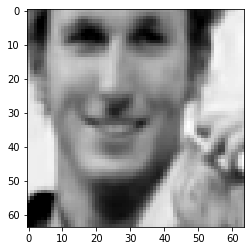

In [41]:
#Looking at one image
import matplotlib.pyplot as plt
%matplotlib inline

def imgshow(x) :
  denorm_x = denorm(x)
  plt.imshow(denorm_x[0], cmap = 'gray')
  plt.show()

#imgshow(img)
denorm_img = denorm(example)
plt.imshow(denorm_img[0], cmap = 'gray')

# Creating a Data Loader Object

In [0]:
#Loader parameters
#batch_size = 50
workers = 4

#Creating DataLoader
from torch.utils.data import DataLoader #returns batch of img and label

data_loader = DataLoader(planes, batch_size = batch_size, shuffle = True, num_workers = workers, pin_memory = True)

Size of Image Batch: 8


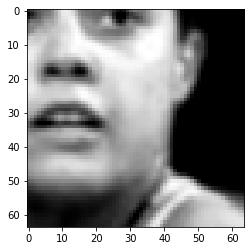

In [43]:
for img_batch in data_loader :
  print('Size of Image Batch:', img_batch.shape[0])    #img_batch dimensions ==>  [batch_size, channel, height, width]
  #print('Size of Label Batch:', label_batch.shape)
  imgshow(img_batch[0])
  break

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

# Defining Generator Architecture

In [0]:
#For generator
import torch.nn as nn
import torch.nn.functional as F

nz = 100 #size of latent vector (noise =100)
ngf = 128 #Number of features to be passed throughout generator
nc = 3 #channels in output image (r,g,b)

class Generator(nn.Module) :
  def __init__(self, ngf) :
    super(Generator, self).__init__()
    self.deconv1 = nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0) #Upsampling through deconv(input_ch, output_ch, kernel_size, stride, padding, bias)
    self.deconv1_bn = nn.BatchNorm2d(ngf * 8) #normalization over channels (since weight in one channel is same,,,weight sharing in channel)
    self.deconv2 = nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1)
    self.deconv2_bn = nn.BatchNorm2d(ngf * 4)
    self.deconv3 = nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1)
    self.deconv3_bn = nn.BatchNorm2d(ngf * 2)
    self.deconv4 = nn.ConvTranspose2d(ngf * 2, ngf * 1, 4, 2, 1)
    self.deconv4_bn = nn.BatchNorm2d(ngf * 1)
    self.deconv5 = nn.ConvTranspose2d(ngf * 1, nc, 4, 2, 1)
    
  def forward(self, z) :
    z = F.relu(self.deconv1_bn(self.deconv1(z)))
    z = F.relu(self.deconv2_bn(self.deconv2(z)))
    z = F.relu(self.deconv3_bn(self.deconv3(z)))
    z = F.relu(self.deconv4_bn(self.deconv4(z)))
    z = torch.tanh(self.deconv5(z))
    return z

  def weight_init(self, mean, std) :
    for m in self._modules :
      normal_init(self._modules[m], mean, std)


# Defining Discriminator Architecture

In [0]:
class Discriminator(nn.Module) :
  def __init__(self, ngf):
    super(Discriminator, self).__init__()
    self.conv1 = nn.Conv2d(nc, ngf*1, 4, 2, 1)
    self.conv2 = nn.Conv2d(ngf * 1, ngf*2, 4, 2, 1)
    self.conv2_bn = nn.BatchNorm2d(ngf * 2)
    self.conv3 = nn.Conv2d(ngf * 2, ngf*4, 4, 2, 1)
    self.conv3_bn = nn.BatchNorm2d(ngf * 4)
    self.conv4 = nn.Conv2d(ngf * 4, ngf*8, 4, 2, 1)
    self.conv4_bn = nn.BatchNorm2d(ngf * 8)
    self.conv5 = nn.Conv2d(ngf * 8, 1, 4, 1, 0)
  
  def forward(self, z) :
    z = F.leaky_relu(self.conv1(z), 0.2)
    z = F.leaky_relu(self.conv2_bn(self.conv2(z)), 0.2)
    z = F.leaky_relu(self.conv3_bn(self.conv3(z)), 0.2)
    z = F.leaky_relu(self.conv4_bn(self.conv4(z)), 0.2)
    z = torch.sigmoid(self.conv5(z))
    return z
  
  def weight_init(self, mean, std) :
    for m in self._modules :
      normal_init(self._modules[m], mean, std)

In [47]:
#Creating network instances
G = Generator(ngf)
G.to(device)
print(G)

D = Discriminator(ngf)
D.to(device)
print(D)

Generator(
  (deconv1): ConvTranspose2d(100, 1024, kernel_size=(4, 4), stride=(1, 1))
  (deconv1_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv2): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv2_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv3_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv4): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (deconv4_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (deconv5): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)
Discriminator(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(

# Creating Optimizers for updating parameters

In [0]:
import torch.optim as optim
#Define BCE Loss Function
criterion = nn.BCELoss()
lr = 0.0002


#Defining optimizers to carry out backprop
g_optimizer = optim.Adam(G.parameters(), lr = lr, betas = (0.5, 0.999))
d_optimizer = optim.Adam(D.parameters(), lr = lr, betas = (0.5, 0.999))



# Making paths to save results

In [0]:
# results save folder
if not os.path.isdir('Face_DCGAN_results'):
    os.mkdir('Face_DCGAN_results')
if not os.path.isdir('Face_DCGAN_results/Random_results'):
    os.mkdir('Face_DCGAN_results/Random_results')
if not os.path.isdir('Face_DCGAN_results/Fixed_results'):
    os.mkdir('Face_DCGAN_results/Fixed_results')

In [0]:
#setting accumulated gradients to zero

def reset_grads() :
  d_optimizer.zero_grad()
  g_optimizer.zero_grad()

# Function for training Discriminator

In [0]:
def train_discriminator(images) :
  #create labels which are later used for bceloss
  real_labels = torch.ones(batch_size).to(device)
  fake_labels = torch.zeros(batch_size).to(device)

  #Get real loss
  d_outs = D(images).squeeze()
  d_loss_real = criterion(d_outs, real_labels)
  real_score = d_outs

  #Get fake loss
  #Create batch for latent noise vectors as input to generator
  fixed_noise = torch.randn(batch_size, nz, 1, 1, device = device)
  g_outs = G(fixed_noise)
  ds_outs = D(g_outs).squeeze()
  d_loss_fake = criterion(ds_outs, fake_labels)
  fake_score = ds_outs

  #Combined loss
  d_loss = d_loss_real + d_loss_fake

  #Clear previous gradients
  reset_grads()

  #Compute gradients of loss functions wrt paramters
  d_loss.backward()

  #Carry one step of backpropagation
  d_optimizer.step()

  return d_loss, real_score, fake_score


# Function for training Generator

In [0]:
def train_generator() :
  #Create batch for latent noise vectors as input to generator
  fixed_noise = torch.randn(batch_size, nz, 1, 1, device = device)
  fake_images = G(fixed_noise) #get gen outputs for nois
  d_outputs = D(fake_images).squeeze() #get dis probs for generated fake images
  labels = torch.ones(batch_size).to(device) #create 1 labels 
  g_loss = criterion(d_outputs, labels)  #as we want dis output ---> 1(real)

  #Reset Gradients
  reset_grads()

  #Compute gradients
  g_loss.backward()

  #Adjust parameters using backprop
  g_optimizer.step()

  return g_loss, fake_images

In [0]:
#Place to store model checkpoint
import os

sample_dir = 'sample'
if not os.path.exists(sample_dir) :
  os.makedirs(sample_dir)

#### Saving some real images

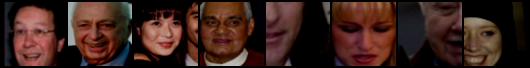

In [60]:
#Saving batch of some real images
from IPython.display import Image as Img
from torchvision.utils import save_image

#save some real images
for x in data_loader :
  x = x.reshape(x.size(0), 3, 64, 64)
  save_image(denorm(x), os.path.join(sample_dir, 'real_images.png'), nrow = 10)
  break
Img(os.path.join(sample_dir, 'real_images.png'))

#### Saving some noise vectors to see changes as generator trains

Saving fake_images-0000.png


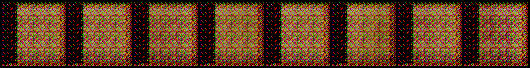

In [61]:
#Saving batch of fake iamges
#Keep same input vector to check evolution of Generator on same input

sample_vectors = torch.randn(batch_size, nz,1 ,1).to(device)

def save_fake_images(index) :
   fake_images = G(sample_vectors)
   fake_images = fake_images.reshape(fake_images.size(0), 3, 64, 64)
   fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
   print('Saving', fake_fname)
   save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow = 10)
  
#before training
save_fake_images(0)
Img(os.path.join(sample_dir, 'fake_images-0000.png'))

# Training GAN

In [63]:
%%time

num_epochs = 5000
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images) in enumerate(data_loader):
        # Load a batch & transform to vectors
        #images = images.reshape(batch_size, -1).to(device)
        images = images.to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 50 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Streaming output truncated to the last 5000 lines.
Epoch [3334/5000], Step [100/123], d_loss: 0.0005, g_loss: 13.1010, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-3335.png
Epoch [3335/5000], Step [50/123], d_loss: 0.0914, g_loss: 5.5825, D(x): 0.92, D(G(z)): 0.00
Epoch [3335/5000], Step [100/123], d_loss: 0.0548, g_loss: 7.4994, D(x): 1.00, D(G(z)): 0.05
Saving fake_images-3336.png
Epoch [3336/5000], Step [50/123], d_loss: 0.0010, g_loss: 9.0600, D(x): 1.00, D(G(z)): 0.00
Epoch [3336/5000], Step [100/123], d_loss: 0.1283, g_loss: 7.6427, D(x): 0.89, D(G(z)): 0.00
Saving fake_images-3337.png
Epoch [3337/5000], Step [50/123], d_loss: 0.0658, g_loss: 7.1018, D(x): 0.95, D(G(z)): 0.01
Epoch [3337/5000], Step [100/123], d_loss: 0.2571, g_loss: 7.6580, D(x): 0.87, D(G(z)): 0.00
Saving fake_images-3338.png
Epoch [3338/5000], Step [50/123], d_loss: 0.0347, g_loss: 4.9048, D(x): 0.97, D(G(z)): 0.00
Epoch [3338/5000], Step [100/123], d_loss: 0.0030, g_loss: 8.1746, D(x): 1.00, D(G(z)): 0.00
Sav

In [0]:
#Save the model

torch.save(G.state_dict(), 'G.ckpt')
torch.save(D.state_dict(), 'D.ckpt')

In [73]:
print(sample_dir)

sample


#### Converting Images to video format

In [0]:
import cv2
import os
from IPython.display import FileLink

vid_fname = 'training2.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'fake_images' in f]
files.sort()
#print(files)
out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 8, (64,64*8))
[out.write(cv2.imread(fname)) for fname in files]
out.release()
FileLink('training2.avi')

# Plotting Training Graphs

In [0]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 10
plt.rcParams["figure.figsize"] = fig_size

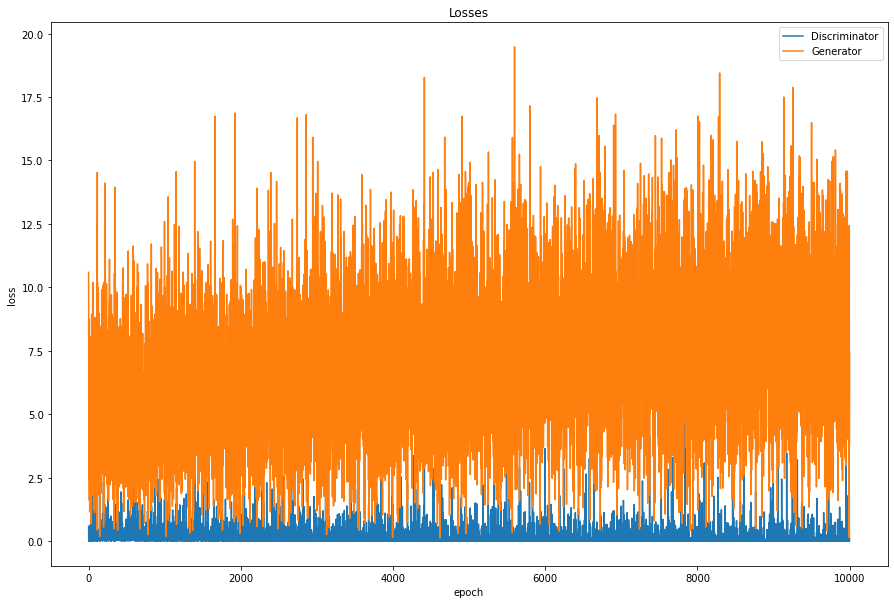

In [71]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

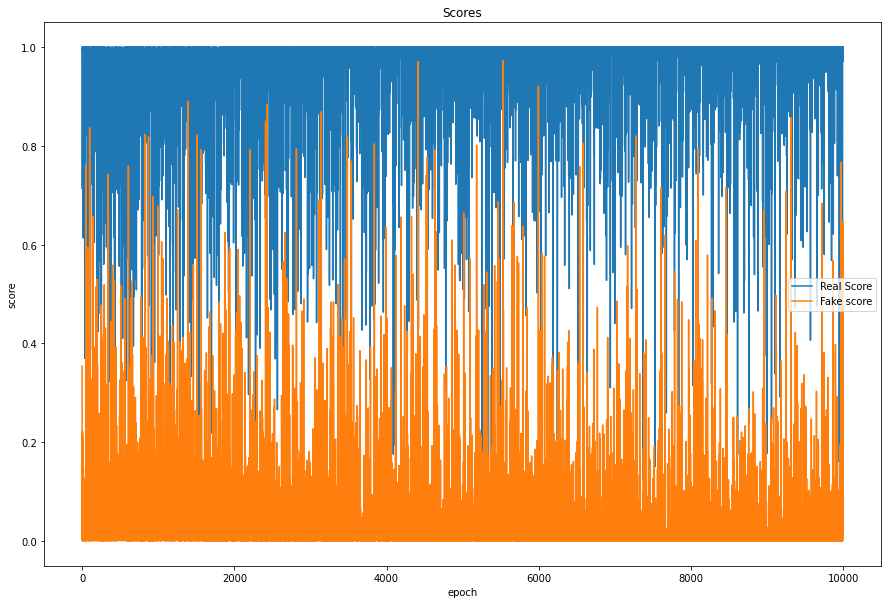

In [72]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real Score', 'Fake score'])
plt.title('Scores');